# EN

最適なalpha: 0.03125
最適なl1ratio: 0.01


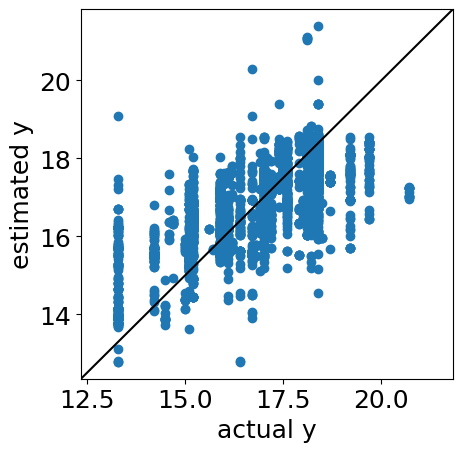

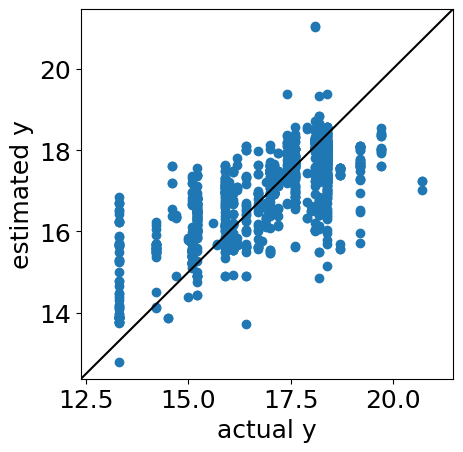

R2 : 訓練 0.5374825599623954, 検証 0.5506598814390969
MAE : 訓練 0.8217391576430021, 検証 0.7971071682819604
RMSE) : 訓練 1.0817567304307258, 検証 1.0506936005021605


,標準回帰係数
Al / Si,-0.012583
Na / Si,-0.019941
K / Si,-0.000005
F / Si,-0.067374
H2O / Si,0.069615
...,...
fr_Ndealkylation2,-0.002380
fr_bicyclic,-0.000000
fr_piperdine,-0.024439
fr_quatN,0.128809


In [1]:
# 前処理
import pandas as pd
dataset=pd.read_csv('dataset_rdkit.csv', index_col=0)
x=dataset.iloc[:, :114]
y=dataset.iloc[:, 122]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.25, shuffle=True, random_state=4)
autoscaled_x_train=(x_train-x_train.mean())/x_train.std()
autoscaled_x_test=(x_test-x_train.mean())/x_train.std()
autoscaled_y_train=(y_train-y_train.mean())/y_train.std()
autoscaled_y_test=(y_test-y_train.mean())/y_train.std()

# ENの実行
import numpy as np
EN_lambdas=2**np.arange(-5, 2, dtype=float)
EN_alphas=np.arange(0.01, 1.00, 0.05, dtype=float)
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
model_for_cross_validation=ElasticNet(max_iter=10000)
gs_cv=GridSearchCV(model_for_cross_validation, {'alpha':EN_lambdas, 'l1_ratio':EN_alphas}, cv=5)
gs_cv.fit(autoscaled_x_train, autoscaled_y_train)
optimal_lambda=gs_cv.best_params_['alpha']
optimal_alpha=gs_cv.best_params_['l1_ratio']

print(f"最適なalpha: {optimal_lambda}")
print(f"最適なl1ratio: {optimal_alpha}")

model=ElasticNet(alpha=optimal_lambda, l1_ratio=optimal_alpha, max_iter=10000)
model.fit(autoscaled_x_train, autoscaled_y_train)

# FDの予測
estimated_y_train=pd.DataFrame(model.predict(autoscaled_x_train))
estimated_y_train=estimated_y_train*y_train.std()+y_train.mean()
estimated_y_test=pd.DataFrame(model.predict(autoscaled_x_test))
estimated_y_test=estimated_y_test*y_train.std()+y_train.mean()

import matplotlib.pyplot as plt
import matplotlib.figure as figure

plt.rcParams['font.size'] = 18 
plt.figure(figsize=figure.figaspect(1)) 
plt.scatter(y_train, estimated_y_train.iloc[:, 0]) 
y_max = max(y_train.max(), estimated_y_train.iloc[:, 0].max()) 
y_min = min(y_train.min(), estimated_y_train.iloc[:, 0].min()) 
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-') 
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
plt.xlabel("actual y") 
plt.ylabel("estimated y") 
plt.show() 

plt.rcParams['font.size'] = 18 
plt.figure(figsize=figure.figaspect(1)) 
plt.scatter(y_test, estimated_y_test.iloc[:, 0]) 
y_max = max(y_test.max(), estimated_y_test.iloc[:, 0].max()) 
y_min = min(y_test.min(), estimated_y_test.iloc[:, 0].min()) 
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-') 
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)) 
plt.xlabel("actual y") 
plt.ylabel("estimated y") 
plt.show() 

from sklearn import metrics
r2_train=metrics.r2_score(y_train, estimated_y_train)
r2_test=metrics.r2_score(y_test, estimated_y_test)
MAE_train=metrics.mean_absolute_error(y_train, estimated_y_train)
MAE_test=metrics.mean_absolute_error(y_test, estimated_y_test)
RMSE_train=metrics.root_mean_squared_error(y_train, estimated_y_train)
RMSE_test=metrics.root_mean_squared_error(y_test, estimated_y_test)

print(f"R2 : 訓練 {r2_train}, 検証 {r2_test}")
print(f"MAE : 訓練 {MAE_train}, 検証 {MAE_test}")
print(f"RMSE) : 訓練 {RMSE_train}, 検証 {RMSE_test}")

標準回帰係数_EN = pd.DataFrame((model.coef_), index=x.columns, columns=['標準回帰係数'])
display(標準回帰係数_EN)
                      
標準回帰係数_EN.to_csv('標準回帰係数_EN_rdkit.csv')